# Amazon SageMaker Semantic Segmentation on Satellite Imagery

In this workshop, we will demonstrate how to train and host a semantic segmentation model. In order to train this model, we will be using the Semantic Segmentation built in-algorithm on the SpaceNet dataset with the Deeplab-v3 backbone.

We will use the SpaceNet SN6: Multi-Sensor All-Weather Mapping dataset. The data is hosted on AWS as a [public dataset on Amazon S3](https://registry.opendata.aws/spacenet/). 

Synthetic Aperture Radar (SAR) is a unique form of radar that can penetrate clouds, collect during all- weather conditions, and capture data day and night. In this example, we will process it like a regular image and focus on demonstrating the use of the SageMaker to build and host a Semantic Segmentation model.

The data is over 120 sq km of both high resolution synthetic aperture radar (SAR) data and electro optical (EO) imagery with ~48,000 building footprint labels of Rotterdam, The Netherlands.

> **Left:** SAR Intensity (HH, VV, VH). **Right:** Visible Spectrum Imagery (R,G,B).

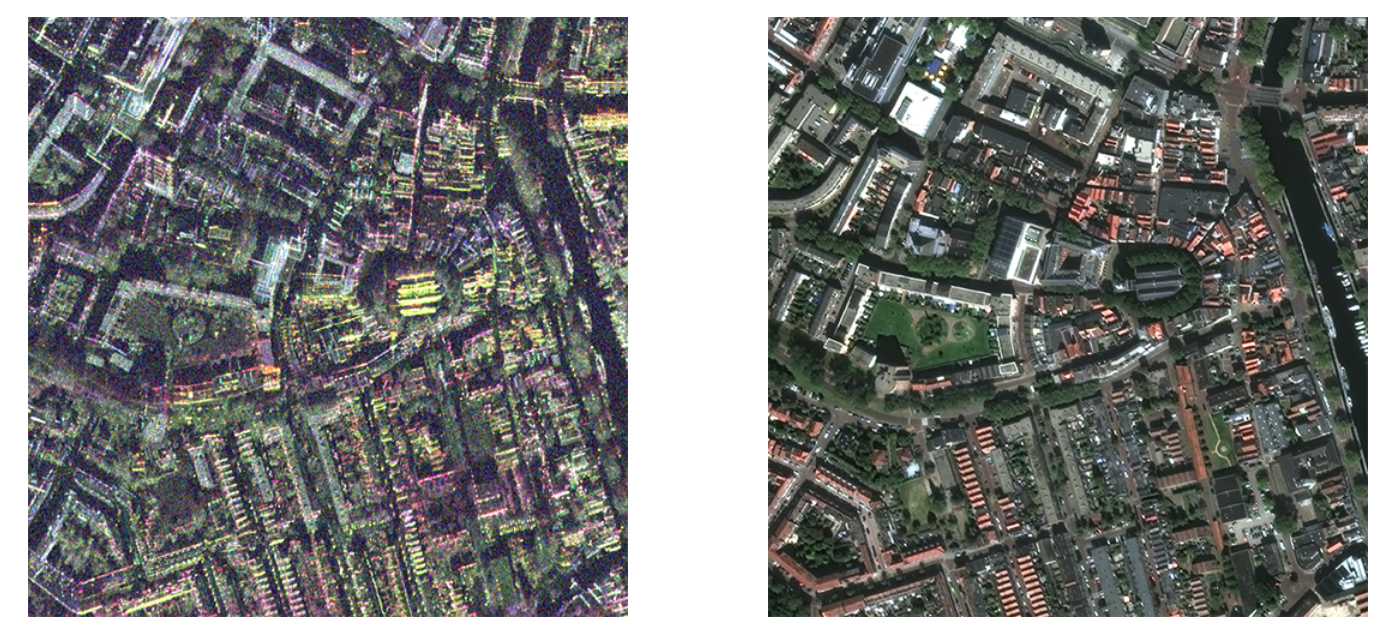

We will start by assembling a training dataset in the format that the training job will consume. After training a model, we will demonstrate how to host and validate the trained model.

The SN6 dataset is 39.0 GB. For the purpose of this workshop and keeping training time short, we will only use a subset of the data to train the algorithm but feel free to modify the notebook to use the entire dataset.


🚨 Use the pre-installed custom gdal kernel to run this notebook: **gdal_python36** 🚨


### Import project dependencies

Before beginning, let's install all the dependencies required in the environement

> **Note:** When developing your own projects, it's recommended to separate lower level code out to a python module to make the notebook more readable. This also makes putting the final code into production format easier as it is already partly modularized.

ℹ️ Next cell will complete in ~11 minutes

In [ ]:
conda env update -f environment.yml

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

### Download data

For the purpose of this worshop, we will use a small subset of the SN6 SpaceNet dataset.

If you have already downloaded and setup the data, you do not need to run the following cells in this section.  If you have downloaded and want to re-download and reprocess the data, run the cell below to clean the previous download. 

ℹ️ Next cell will complete in ~2 minutes

In [ ]:
filename = 'SN6_buildings_AOI_11_Rotterdam_train_small.tar.gz'

!wget http://d1uvw90uyir5vw.cloudfront.net/{filename} -P ../data
!tar -C ../data/ -zxf ../data/{filename}

If you want to work with the full SpaceNet dataset, you can use the following commands instead. Warning, the SpaceNet dataset if large (39GB) and will take a long time to download, process and train.

```
!aws s3 cp s3://spacenet-dataset/spacenet/SN6_buildings/tarballs/SN6_buildings_AOI_11_Rotterdam_train.tar.gz ../data/
!aws s3 cp s3://spacenet-dataset/spacenet/SN6_buildings/tarballs/SN6_buildings_AOI_11_Rotterdam_test_public.tar.gz ../data/

!tar -C ../data/ -zxf ../data/SN6_buildings_AOI_11_Rotterdam_train.tar.gz
!tar -C ../data/ -zxf ../data/SN6_buildings_AOI_11_Rotterdam_test_public.tar.gz
```

### Environement Setup

To train the Semantic Segmentation algorithm on Amazon SageMaker, we need to setup and authenticate the use of AWS services. To begin with, we need an AWS account role with SageMaker access. This role that is used to give SageMaker access to your data in [Amazon S3](https://aws.amazon.com/s3/) can automatically be obtained from the role used to start the notebook.



In [ ]:
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker.session.Session().boto_region_name

We also need the S3 bucket that is used to store training data and the trained model artifacts. In this notebook, we use the default bucket that comes with Sagemaker. However, you can also create a bucket and use that bucket instead.

In [ ]:
bucket = sagemaker_session.default_bucket()
prefix = 'sar/spacenet6-demos/building-detection'

### The Multi-Sensor All Weather Mapping (MSAW) dataset

This dataset features a unique combination of half-meter quad-polarized X-band SAR imagery and halfmeter optical imagery over the port of Rotterdam, the Netherlands. The dataset covers a total area of 120km2 and is labeled with 48,000 unique building footprints, along with associated height information.

The aerial collect captures the same area of Rotterdam multiple times and features 204 individual image strips captured over a three day span: August 4th, 23rd, and 24th 2019. Each strip features four polarizations (HH, HV, VH, and VV) of data in the X-band wavelength.

For more information on the dataset: https://openaccess.thecvf.com/content_CVPRW_2020/papers/w11/Shermeyer_SpaceNet_6_Multi-Sensor_All_Weather_Mapping_Dataset_CVPRW_2020_paper.pdf

In [ ]:
from osgeo import gdal

def prepare_image_data(path):
    raster = gdal.Open(path)
    data = raster.ReadAsArray()
    data = np.moveaxis(data, 0, -1)
    return data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#tile = '20190804145216_20190804145445_tile_6513'
tile = '20190804113009_20190804113242_tile_4799'

filepath = r"../data/train/AOI_11_Rotterdam/PS-RGB/SN6_Train_AOI_11_Rotterdam_PS-RGB_{}.tif".format(tile)
sarpath = r"../data/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_{}.tif".format(tile)

fig = plt.figure(figsize = (15,10))

ax1 = fig.add_subplot(2,3,1)
ax1.title.set_text('IMG')
tile_img = prepare_image_data(filepath)
ax1.imshow(tile_img)

ax2 = fig.add_subplot(2,3,2)
ax2.title.set_text('SAR')
sardata = prepare_image_data(sarpath)/255
ax2.imshow(sardata)

ax3 = fig.add_subplot(2,3,3)
ax3.title.set_text('SAR channels (HH, HV, VH, VV)')
ax3.imshow(sardata[:,:,0],cmap='gray')

ax4 = fig.add_subplot(2,3,4)
ax4.title.set_text('SAR channel 1')
ax4.imshow(sardata[:,:,1],cmap='gray')

ax5 = fig.add_subplot(2,3,5)
ax5.title.set_text('SAR channel 2')
ax5.imshow(sardata[:,:,2],cmap='gray')

ax6 = fig.add_subplot(2,3,6)
ax6.title.set_text('SAR channels 3')
ax6.imshow(sardata[:,:,3],cmap='gray')

The folder SummaryData contains a CSV of building footprint locations in pixel coordinates and orientation file indicating the directions from which each SAR image is captured (0 North, 1 South). We will use this file to generate the labels (masks) for the training dataset.

In [ ]:
import pandas as pd
building_labels = pd.read_csv('../data/train/AOI_11_Rotterdam/SummaryData/SN6_Train_AOI_11_Rotterdam_Buildings.csv')

We will use the following script to convert polygon labels from df into label masks for each image

In [ ]:
!pygmentize spacenet_utils.py

Here is an example of a mask for a sample tile.

In [ ]:
import spacenet_utils
import cv2

example_mask = spacenet_utils.generate_mask_for_image_and_class((900,900),tile,building_labels)

fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(1,3,1)
ax1.title.set_text('IMG')
ax1.imshow(tile_img)

ax2 = fig.add_subplot(1,3,2)
ax2.title.set_text('MASK')
ax2.imshow(example_mask)

ax3 = fig.add_subplot(1,3,3)
ax3.title.set_text('CUT MASK')
example_mask[example_mask==1] = 255
mask_inv = cv2.bitwise_not(example_mask)
newdata = cv2.bitwise_and(tile_img, tile_img, mask = mask_inv)
ax3.imshow(newdata)

### 2. Pre-processing & mask generation for all training set

In [ ]:
building_labels_list = building_labels['ImageId'].drop_duplicates().tolist()

print("{} unique masks".format(len(building_labels_list)))

We tile all data to 450m×450m (900pixels×900pixels) tiles. We first tile the SAR imagery, and then tile the optical collects to match the corresponding SAR extent and pixel grid. We then mask the optical data using the extent of each SAR image that contains valid imagery. Finally we clip our polygon labels to match each tile extent, again removing polygons that do not contain any valid SAR imagery. 

In [ ]:
%%time
import os
masks_directory = "masks/"
if not os.path.exists(masks_directory): os.mkdir(masks_directory)

# Let's save the names of the valid masks to build our training and validation set
valid_images_name = []

for img in building_labels_list:
    try:
        filename = masks_directory + img + '.png'
        mask = spacenet_utils.generate_mask_for_image_and_class((900,900),img,building_labels)
        cv2.imwrite(filename,mask)
        valid_images_name.append(img)
    except:
        pass

### 3. Setup data

Move the images into appropriate directory structure as described in the documentation. This is quite simply, moving the training images to train directory and so on. Fortunately, the dataset's annotations are already named in sync with the image names, satisfying one requirement of the Amazon SageMaker Semantic Segmentation algorithm.

The following directory structure that is used.

```bash
root 
|-train/
|-train_annotation/
|-validation/
|-validation_annotation/

```

In [ ]:
train_annotation_channel = 'train_annotation'
val_annotation_channel = 'validation_annotation'
train_channel = 'train'
val_channel = 'validation'
test_channel = 'test'
test_annotation_channel = 'test_annotation'
os.makedirs('train', exist_ok=True)
os.makedirs('validation', exist_ok=True)
os.makedirs('train_annotation', exist_ok=True)
os.makedirs('validation_annotation', exist_ok=True)
os.makedirs('test',exist_ok=True)
os.makedirs('test_annotation',exist_ok=True)

We split the tiled data into three sets: 80% for training, 20% for validation. A separate test dataset is available for testing and for final scoring for the challenge.

In [ ]:
from sklearn.model_selection import train_test_split

# Let's split the data in training set and test set
train_data, test_data = train_test_split(valid_images_name,test_size=0.1, random_state=42)

# We will split once more for get a validation set
train_data, validation_data = train_test_split(train_data,test_size=0.2,random_state=42)

The data in the SpaceNet dataset, like many other satelitte and aerial photography imagery, is provided in the .tif format.

A GeoTIFF is a standard .tif or image file format that includes additional spatial (georeferencing) information embedded in the .tif file as tags. We will use a famous library, GDAL, to process those images and extract the jpeg image format.


In [ ]:
%%time

import sys

data_directory = '../data/train/AOI_11_Rotterdam/SAR-Intensity'

for filename in os.listdir(data_directory):
    try:
        if filename in train_data or validation_data:
            raster = gdal.Open("{}/{}".format(data_directory,filename))
            data = raster.ReadAsArray()
            data = np.moveaxis(data, 0, -1)
            img_name = filename[41:-4]
            if img_name in train_data:
                cv2.imwrite("{}/{}.jpg".format(train_channel,img_name), data[:,:,0])
            elif img_name in validation_data:
                cv2.imwrite("{}/{}.jpg".format(val_channel,img_name), data[:,:,0])
            elif img_name in test_data:
                cv2.imwrite("{}/{}.jpg".format(test_channel,img_name), data[:,:,0])
    except:
        pass

In [ ]:
from shutil import copyfile

for filename in train_data:
    copyfile("{}{}.png".format(masks_directory,filename),"{}/{}.png".format(train_annotation_channel,filename))
for filename in validation_data:
    copyfile("{}{}.png".format(masks_directory,filename),"{}/{}.png".format(val_annotation_channel,filename))
for filename in test_data:
    copyfile("{}{}.png".format(masks_directory,filename),"{}/{}.png".format(test_annotation_channel,filename))

Let's now upload the dataset to S3

In [ ]:
%%time

for channel in [train_channel, val_channel,train_annotation_channel,val_annotation_channel]:
    !aws s3 cp ./{channel}/ s3://{bucket}/{prefix}/data/{channel}/ --recursive --quiet

Next we need to setup an output location at S3, where the model artifact will be dumped. These artifacts are also the output of the algorithm's traning job. Let us use another channel in the same S3 bucket for this purpose.

In [ ]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Model data will be saved to: {}'.format(s3_output_location))

Lastly, we need the Amazon SageMaker Semantic Segmentation container image, which is static and need not be changed.

In [ ]:
## get training image for built-in algorithm

from sagemaker.amazon.amazon_estimator import get_image_uri
training_image = get_image_uri(sagemaker_session.boto_region_name, 'semantic-segmentation', repo_version="latest")

print(training_image)

### Training

Now that we are done with all the setup that is needed, we are ready to train our segmentation algorithm. To begin, we create a sagemaker.estimator.Estimator object. This estimator configures the training job, that we can then run calling the .fit() method. We will use a GPU instance (ml.p3.2xlarge) to train.

In [ ]:
# Create the sagemaker estimator object.
ss_model = sagemaker.estimator.Estimator(training_image,                     # the semantic segmentation image defined in the previous cell
                                         role,                               # passing on the role to the training job for S3 access
                                         train_instance_count=1,             # the number of instances on which to train our model
                                         train_instance_type='ml.p2.xlarge', # the type of instance, here we need a GPU so we will use an instance from the P familly
                                         train_volume_size=50,               # the volume size for the training instances
                                         train_max_run=360000,               # a stop condition after 360000 seconds of the training job run 
                                         output_path=s3_output_location,     # the location in  S3 to store our training artefacts, like the model itself
                                         sagemaker_session=sagemaker_session)# the sagemaker session


The semantic segmentation algorithm at its core has two compoenents.

- An encoder or backbone network,
- A decoder or algorithm network.

The encoder or backbone network is typically a regular convolutional neural network that may or may not have had their layers pre-trained on an alternate task such as the classification task of ImageNet images. The Amazon SageMaker Semantic Segmentation algorithm comes with two choices of pre-trained or to be trained-from-scratch backbone networks (ResNets 50 or 101).

The decoder is a network that picks up the outputs of one or many layers from the backbone and reconstructs the segmentation mask from it. Amazon SageMaker Semantic Segmentation algorithm comes with a choice of the Fully-convolutional network (FCN) or the Pyramid scene parsing (PSP) network.

The algorithm also has ample options for hyperparameters that help configure the training job. The next step in our training, is to setup these networks and hyperparameters along with data channels for training the model. Consider the following example definition of hyperparameters. See the SageMaker Semantic Segmentation documentation for more details on the hyperparameters.

One of the hyperparameters here for instance is the epochs. This defines how many passes of the dataset we iterate over and determines that training time of the algorithm. For the sake of demonstration let us run only 10 epochs. Based on our tests, train the model for X epochs with similar settings should give us 'reasonable' segmentation results on the SAR dataset. For the most part, we will stick to using the simplest of settings. For more information on the hyperparameters of this algorithm, [refer to the documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/segmentation-hyperparameters.html).

In [ ]:
ss_model.set_hyperparameters(backbone='resnet-50',                  # resnet-50 has less layers than resnet-101 so will train faster. You can experiment with resnet 101 on the full dataset.
                             algorithm='deeplab',                   # deeplab gave good outcomes in this example. You can experiment with FCN and PSP
                             num_classes=2,                         # the building class and the non-building class in this example
                             epochs=10,                             # for the workshop, we will use a low number of epochs. Feel free to experiment with more epochs on the full dataset
                             learning_rate=0.0001,                  # the learning rate was selected after an hyperparameter tuning job
                             optimizer='adam',                      # adam does well on most problems
                             mini_batch_size=16,                    # smaller batch size will improve training time, you can experiment with this parameter
                             validation_mini_batch_size=16,         # smaller batch size will improve training time, you can experiment with this parameter
                             num_training_samples=len(train_data))  # the number of training samples


Now that the hyperparameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the sagemaker.session.s3_input objects from our data channels. These objects are then put in a simple dictionary, which the algorithm uses to train.

In [ ]:
s3_train_data = 's3://{}/{}/data/{}/'.format(bucket, prefix, train_channel)
s3_train_annotation = 's3://{}/{}/data/{}/'.format(bucket, prefix, train_annotation_channel)
s3_val_data = 's3://{}/{}/data/{}/'.format(bucket, prefix, val_channel)
s3_val_annotation = 's3://{}/{}/data/{}/'.format(bucket, prefix, val_annotation_channel)


# Create sagemaker s3_input objects
distribution = 'FullyReplicated'

train_data = sagemaker.session.s3_input(s3_train_data, distribution=distribution, 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution=distribution, 
                                        content_type='image/png', s3_data_type='S3Prefix')
val_data = sagemaker.session.s3_input(s3_val_data, distribution=distribution, 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')
val_annotation = sagemaker.session.s3_input(s3_val_annotation, distribution=distribution, 
                                        content_type='image/png', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 
                 'validation': val_data,
                 'train_annotation': train_annotation, 
                 'validation_annotation': val_annotation}

We have:
- created an Estimator object, that uses the defined Semantic Segmentation algorithm container
- defined a set the hyperparameters for this Estimator object and specific algorithm
- the data channels inputs for our algorithm

The only remaining thing to do is to train the algorithm. The next command will train the algorithm. 

Training the algorithm involves a few steps. Firstly, the instances that we requested while creating the Estimator classes are provisioned and are setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. When complete, the model artefact will be uploaded to S3 to the specified output location. This is what happens under the hood:

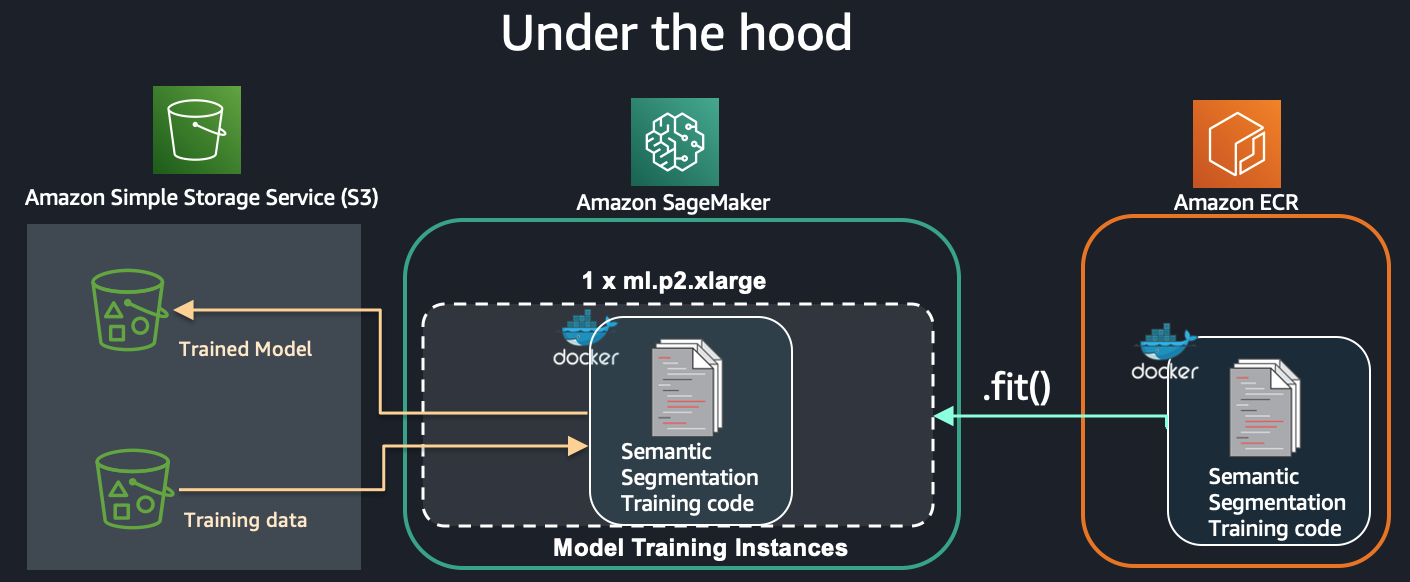

The provisioning and data downloading will take time, depending on the size of the data and the availability of the type of instances. Therefore it might be a few minutes before we start getting data logs for our training jobs. 

The data logs will also print out training loss on the training data, which is the pixel-wise cross-entropy loss as described in the [algorithm papers](https://arxiv.org/abs/1706.05587). The data logs will also print out pixel-wise label accuracy and mean intersection-over-union (mIoU) on the validation data after a run of the dataset once or one epoch. These metrics measure the quality of the model under training.

Once the job has finished a "Job complete" message will be printed. The trained model can be found in the S3 bucket that was setup as output_path in the estimator.

ℹ️ Next cell will complete in ~13 minutes

In [ ]:
%%time

ss_model.fit(inputs=data_channels)

### Hosting

Once the training is done, we can deploy the trained model as an Amazon SageMaker hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same instance (or type of instance) that we used to train. Training is prolonged and compute heavy, often having different compute and memory requirements to hosting. We can choose any sagemaker supported instance we want to host the model. 

In this example, we will deploy a model previously trained as we need to train of a larger dataset to get good outcomes. If you want to deploy the model you trained yourself, simply skip the next cell.

In [ ]:
!wget http://d1uvw90uyir5vw.cloudfront.net/sm_deeplab_model.tar.gz
!aws s3 cp ./sm_deeplab_model.tar.gz s3://{bucket}/sagemaker/model/sm_deeplab_model.tar.gz
import random    

endpoint_name = 'building-detection-deeplab-{:04d}'.format(random.randint(0, 1000))


ss_model = sagemaker.model.Model(image=training_image, 
                              model_data=f's3://{bucket}/sagemaker/model/sm_deeplab_model.tar.gz', 
                              role=role,
                              sagemaker_session=sagemaker_session)

Let's deploy our model

ℹ️ Next cell will complete in ~8 minutes

In [ ]:
ss_model.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge', endpoint_name=endpoint_name)
predictor = sagemaker.predictor.RealTimePredictor(endpoint_name, sagemaker_session=sagemaker_session)

### Inference

Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference

In [ ]:
# You can try different test tiles from the test folder
test_tile = '20190804111224_20190804111453_tile_8695'
#test_tile = '20190804111224_20190804111453_tile_8699'

test_filepath = "./test/{}.jpg".format(test_tile)
test_img = plt.imread(test_filepath)
plt.imshow(test_img,cmap='gray')



Let us convert the image to bytearray before we supply it to our endpoint.




The endpoint accepts images in formats similar to the ones found images in the training dataset. It accepts the image/jpeg content_type. The accept parameter takes on two values: image/png and application/x-protobuf. For customers who want an indexed-PNG segmentation mask such as the ones that were used during training, can use the image/png accept type as shown in the example below. Using this endpoint will return a image bytearray.


In [ ]:
# Converting the numpy array to jpg bytearray for the predictor
is_success, im_buf_arr = cv2.imencode(".jpg", test_img)
byte_im = im_buf_arr.tobytes()

In [ ]:
# Setting up the endpoint content type: in this case, the endpoint will receive the SAR data as jpeg bytearray and return a mask as a png bytearray
predictor.content_type = 'image/jpeg'
predictor.accept = 'image/png'

return_img = predictor.predict(byte_im)



Let us display the segmentation mask.

In [ ]:
# decoding the png bytearray received before displaying it
mask = cv2.imdecode(np.frombuffer(return_img, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
plt.imshow(mask)

The second accept type allows us to request all the class probabilities for each pixel. Let us use our endpoint to try to predict the probabilities of segments within this image. Since the image is jpeg, we will use the appropriate content type to run the prediction job. The endpoint returns a file that we can simply load and peek into.

In [ ]:
predictor.content_type = 'image/jpeg'
predictor.accept = 'application/x-protobuf'
results = predictor.predict(byte_im)

What we receive back is a recordio-protobuf of probabilities sent as a binary. You can learn more about the recordio format [here](https://mxnet.apache.org/versions/1.7.0/api/architecture/note_data_loading.html#data-format). It takes a little bit of effort to convert into a readable array. Let us convert them to numpy format. We can make use of mxnet that has the capability to read recordio-protobuf formats. Using this, we can convert the outcoming bytearray into numpy array.

In [ ]:
from sagemaker.amazon.record_pb2 import Record
import mxnet as mx

results_file = 'results.rec'
with open(results_file, 'wb') as f:
    f.write(results)

rec = Record()
recordio = mx.recordio.MXRecordIO(results_file, 'r')
protobuf = rec.ParseFromString(recordio.read())



The protobuf array has two parts to it. The first part contains the shape of the output and the second contains the values of probabilites. Using the output shape, we can transform the probabilities into the shape of the image, so that we get a map of values. There is typically a singleton dimension since we are only inferring on one image. We can also remove that using the squeeze method.

In [ ]:
values = list(rec.features["target"].float32_tensor.values)
shape = list(rec.features["shape"].int32_tensor.values)
shape = np.squeeze(shape)
mask = np.reshape(np.array(values), shape)
mask = np.squeeze(mask, axis=0)

We can now plot the segmentation mask from the list of probabilities for the building class 1. The brighter yellow, the more confident the algorithm is that the class of the pixel is building.

We will also get the indices of the most probable class for each pixel. We can do this by measuring the argmax across the classes axis of the probability data. To plot the probabilites as image, we can use the numpy.argmax method to find out which probabilities are the largest and plot only those as a segmentation mask.

In [ ]:
fig = plt.figure(figsize = (15,10))
ax1.title.set_text('Probability for a pixel to be a building')
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(mask[1])
ax2.title.set_text('Selecting the largest probability for each pixel')
pred_map = np.argmax(mask, axis=0)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(pred_map)

In [ ]:
import os
test_list = [filename[:-4] for filename in os.listdir('./test')]

print("There are {} test images".format(len(test_list)))

Let's use everything that we did to predict and visualize some results!

In [ ]:
def display_results(imname):
    sar_image = './test/' + imname + '.jpg'
    masktrue = cv2.imread('masks/' + imname + '.png', 0)
    optimage = cv2.imread('../data/train/AOI_11_Rotterdam/PS-RGB/SN6_Train_AOI_11_Rotterdam_PS-RGB_' + imname + '.tif')
        
    predictor.content_type = 'image/jpeg'
    predictor.accept = 'image/png'
    
    sar_img = plt.imread(sar_image)
    is_success, im_buf_arr = cv2.imencode(".jpg", sar_img)
    byte_im = im_buf_arr.tobytes()

    return_img = predictor.predict(byte_im)
    mask = cv2.imdecode(np.frombuffer(return_img, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)


    fig = plt.figure(figsize = (15,10))
    ax1 = fig.add_subplot(1,4,1)
    ax1.title.set_text('SAR image')
    ax1.imshow(sar_img,cmap='gray')
    ax2 = fig.add_subplot(1,4,2)
    ax2.title.set_text('Prediction')
    ax2.imshow(mask)
    ax3 = fig.add_subplot(1,4,3)
    ax3.title.set_text('Ground Truth')
    ax3.imshow(masktrue)
    ax4 = fig.add_subplot(1,4,4)
    ax4.title.set_text('Optical Image')
    ax4.imshow(optimage)

You can visualize the results with different images from the test list:

In [ ]:
display_results(imname = test_list[1])

In [ ]:
display_results(imname = test_list[2])

In [ ]:
display_results(imname = test_list[10])

When you are done, don't forget to delete your endpoint!

In [ ]:
predictor.delete_endpoint()